## Import

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns # seaborn là thư viện được xây trên matplotlib, 
                      # giúp việc visualization đỡ khổ hơn
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn import set_config
set_config(display='diagram') # Để trực quan hóa pipeline

# You can also import other things ...
# YOUR CODE HERE (OPTION)
import csv
from sklearn.linear_model import LinearRegression

%matplotlib inline

## Thu thập dữ liệu

In [2]:
# Đọc dữ liệu từ "data.csv"
df = pd.read_csv('data.csv')
df

,sqft,homeType,beds,parkingSpots,lotSize,baths,listPrice,heating_system,cooling_system,view_type,architecture_style,yearBuilt,has_pool,city,address,tax
0,1100.0,Single Family Residential,3,NaN,3781.0,2,235000,Forced Air (Natural Gas),Central A/C,NaN,Other,1955.0,NaN,Chicago,3932 West 84th Street,2642.29
1,2200.0,Single Family Residential,4,2.0,4234.0,3,260000,Forced Air (Natural Gas),Central A/C,NaN,Bungalow,1915.0,NaN,Chicago,1119 North Lockwood Avenue,2938.45
2,750.0,Condo/Coop,2,NaN,NaN,1,275000,Forced Air (Natural Gas),Central A/C,NaN,Other,1926.0,NaN,Chicago,1100 North Paulina Street #1M,4722.00
3,1248.0,Single Family Residential,3,2.0,5279.0,2,309900,NaN,Central A/C,NaN,Ranch,1962.0,NaN,Chicago,4909 North Normandy Avenue,560.03
4,1337.0,Single Family Residential,3,2.0,NaN,2,324900,Forced Air (Natural Gas),Central A/C,NaN,Georgian,1949.0,NaN,Chicago,10034 South Artesian Avenue,77.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160,762.0,Condo/Coop,1,1.0,NaN,1,129900,NaN,Central A/C,NaN,Other,1973.0,True,Chicago,655 West Irving Park Road #315,2283.97
1161,660.0,Condo/Coop,0,NaN,NaN,1,142500,NaN,Central A/C,NaN,Other,1910.0,NaN,Chicago,780 South Federal Street #1202,2755.93
1162,800.0,Condo/Coop,1,1.0,NaN,1,195000,NaN,Window Unit(s) A/C,NaN,Other,1985.0,NaN,Chicago,801 South Plymouth Court #804,3007.72
1163,800.0,Condo/Coop,1,1.0,NaN,1,199999,Forced Air (Natural Gas),Central A/C,NaN,Other,1905.0,NaN,Chicago,1110 West LELAND Avenue #3A,2127.64


---

## Khám phá dữ liệu (để làm rõ câu hỏi)

### Số dòng và cột

In [3]:
df.shape

(1165, 16)

### Ý nghĩa của từng dòng. Có dòng nào không phù hợp không?

Mỗi dòng thể hiện 17 thông tin khác nhau của một căn nhà được giao bán. Do dữ liệu được lấy trong trang mô tả chi tiết của từng căn nhà nên sẽ không có dòng nào đặc biệt.

Tuy nhiên người đăng có thể giao bán 1 căn nhà nhiều lần, các dòng có thể bị lặp lại.

### Kiểm tra số dòng bị lặp lại

In [4]:
df.duplicated().sum()

1

$\to$ Sẽ được đưa vào Pipeline tiền xử lí chung trong tệp huấn luyện

### Ý nghĩa của mỗi cột

In [5]:
df.head(1)

,sqft,homeType,beds,parkingSpots,lotSize,baths,listPrice,heating_system,cooling_system,view_type,architecture_style,yearBuilt,has_pool,city,address,tax
0,1100.0,Single Family Residential,3,NaN,3781.0,2,235000,Forced Air (Natural Gas),Central A/C,NaN,Other,1955.0,NaN,Chicago,3932 West 84th Street,2642.29


Your answer here
- "bedrooms" : Số phòng ngủ
- "bathrooms" : Số phòng vệ sinh
- "house_type" : Loại hình nhà ở
- "length" : Chiều dài căn nhà
- "width" : Chiều rộng căn nhà
- "furniture" : Tình trạng của nội thất
- "legal_paper" : Giấy tờ pháp lý hiện có
- "address" : Địa chỉ của căn nhà
- "direction" : Hướng của cửa chính
- "price" : Giá tiền hiện giao bán

## Làm rõ câu hỏi

**Câu hỏi đưa ra:** Với một căn nhà mơ ước, người khách hàng cần bao nhiêu tiền để có thể mua được ở bang Chicago của Mỹ ? 

Tạm thời các cột Input sẽ là thông tin liên quan tới căn nhà được giao bán, tổng cộng có 16 cột. Cột Output sẽ là giá bán của ngôi nhà. Nhóm sẽ sử dụng mô hình hồi quy để dự đoán giá nhà (cột Output) dựa trên thông tin của căn nhà (cột Input).

Các cột Input có thể thay đổi ở các bước tiền xử lý sau.

**Lợi ích khi trả lời**: 

Có thể đưa ra một mức giá sấp xỉ để những người trẻ có thể dựa vào đó để nổ lực phấn đấu mua được căn nhà mình muốn.

## Khám phá dữ liệu (để tách các tập)
Để biết cách tách các tập thì ta cần khám phá thêm cột output một ít:
- Cột này hiện có kiểu dữ liệu là gì? Trong bài toán hồi qui thì cột output bắt buộc phải có dạng số; nếu hiện chưa có dạng số (ví dụ, số nhưng được lưu dưới dạng chuỗi) thì ta cần chuyển sang dạng số rồi mới tách các tập.
- Cột này có giá trị thiếu không? Nếu có giá trị thiếu thì ta sẽ bỏ các dòng mà output có giá trị thiếu rồi mới tách các tập 
- Cột numerical output xử lí như nào?

In [6]:
# Kiểu dữ liệu cột output
df['listPrice'].dtype

dtype('int64')

In [7]:
# Có giá trị nào thiếu không?
df['listPrice'].isna().sum()

0

---

## Tiền xử lý tách tập dữ liệu

In [8]:
# Tách X và y
y = df["listPrice"] 
X = df.drop("listPrice", axis=1)

In [9]:
# Tách tập huấn luyện và tập validation và tập test theo tỉ lệ 60:20:20
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                               test_size=0.2)

In [10]:
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, 
                                               test_size=0.2)

In [11]:
print("train_X.shape: ", train_X.shape)
print("train_y.shape: ", train_y.shape)

print("val_X.shape: ", val_X.shape)
print("val_y.shape: ", val_y.shape)

print("test_X.shape: ", test_X.shape)
print("test_y.shape: ", test_y.shape)

train_X.shape:  (745, 15)
train_y.shape:  (745,)
val_X.shape:  (187, 15)
val_y.shape:  (187,)
test_X.shape:  (233, 15)
test_y.shape:  (233,)


---

## Khám phá dữ liệu (trên tập huấn luyện)

### Kiểu dữ liệu từng cột. Có cột nào chưa phù hợp?

In [12]:
train_X.dtypes

sqft                  float64
homeType               object
beds                    int64
parkingSpots          float64
lotSize               float64
baths                   int64
heating_system         object
cooling_system         object
view_type             float64
architecture_style     object
yearBuilt             float64
has_pool               object
city                   object
address                object
tax                   float64
dtype: object

### Các cột dạng numerical phân bố như thế nào?

In [13]:
train_X.dtypes[train_X.dtypes != object]

sqft            float64
beds              int64
parkingSpots    float64
lotSize         float64
baths             int64
view_type       float64
yearBuilt       float64
tax             float64
dtype: object

In [14]:
num_cols = ['sqft',"beds","parkingSpots","lotSize","baths","view_type","yearBuilt","tax"]
num_df = train_X[num_cols]
def missing_percentage(c):
    return (c.isna().mean() * 100).round(1)
def median(c):
    return c.quantile(0.5).round(1)
num_df.agg([missing_percentage,'mean','std','min', median, 'max'])

,sqft,beds,parkingSpots,lotSize,baths,view_type,yearBuilt,tax
missing_percentage,20.100000,0.000000,19.900000,42.800000,0.000000,100.0,10.300000,4.400000
mean,1512.593277,2.797315,2.160804,5530.852113,1.969128,NaN,1949.576347,4164.616545
std,753.433034,1.104971,6.939161,10947.463114,0.856890,NaN,37.180606,4594.366862
min,470.000000,0.000000,0.000000,0.000000,1.000000,NaN,1868.000000,105.340000
median,1313.000000,3.000000,2.000000,3781.000000,2.000000,NaN,1951.000000,3297.500000
max,7600.000000,4.000000,100.000000,127631.000000,5.000000,NaN,2021.000000,86621.360000


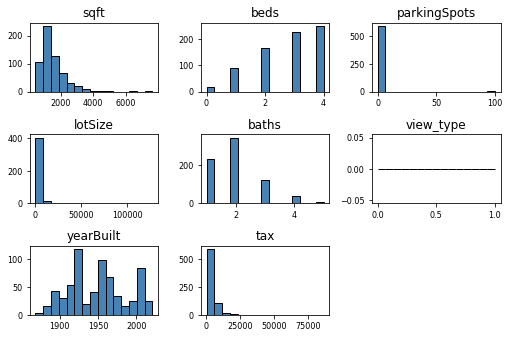

In [15]:
num_df.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False) 
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   

### Các cột dạng categorical phân bố như thế nào?

In [16]:
train_X.dtypes[train_X.dtypes == object]

homeType              object
heating_system        object
cooling_system        object
architecture_style    object
has_pool              object
city                  object
address               object
dtype: object

In [17]:
cate_cols = list(set(train_X.columns) - set(num_cols))
cate_df = train_X[cate_cols]
pd.set_option('display.max_colwidth', 200)
def num_values(df):
    return df.nunique()
def value_percentages(c):
    return dict((c.value_counts(normalize=True) * 100).round(1))
cate_df.agg([missing_percentage, num_values, value_percentages])

,address,heating_system,has_pool,homeType,architecture_style,cooling_system,city
missing_percentage,0.0,28.6,98.0,0.0,0.0,1.2,0.0
num_values,744,21,1,4,16,4,1
value_percentages,"{'3817 West 55th Place': 0.3, '7311 South Wolcott Avenue': 0.1, '1808 South State Street #101': 0.1, '5617 North Nottingham Avenue': 0.1, '3004 North Normandy Avenue': 0.1, '899 South Plymouth Cou...","{'Forced Air (Natural Gas)': 57.7, 'Fireplace (Natural Gas)': 10.2, 'Forced Air': 8.6, 'Hot Water': 5.3, 'Baseboard': 3.2, 'Baseboard (Natural Gas)': 3.2, 'Hot Water (Natural Gas)': 3.0, 'Radiator...",{True: 100.0},"{'Single Family Residential': 62.6, 'Condo/Coop': 36.9, 'Townhouse': 0.4, 'Other': 0.1}","{'Other': 63.4, 'Bungalow': 10.3, 'Ranch': 6.8, 'High Rise': 6.2, 'Cape Cod': 3.5, 'Loft': 2.1, 'Georgian': 1.7, 'Split Level': 1.1, 'English': 0.9, 'Contemporary': 0.8, 'Cottage': 0.8, 'Tudor': 0...","{'Central A/C': 72.3, 'Window Unit(s) A/C': 13.9, 'None': 13.7, 'Zoned A/C': 0.1}",{'Chicago': 100.0}


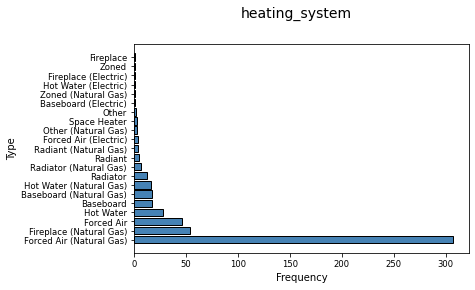

In [18]:
w_q = cate_df['heating_system'].value_counts()
w_q = (list(w_q.index), list(w_q.values))

fig = plt.figure(figsize = (6, 4))
title = fig.suptitle("heating_system", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax = fig.add_subplot(1,1, 1)
ax.set_ylabel("Type")
ax.set_xlabel("Frequency") 
ax.tick_params(axis='both', which='major', labelsize=8.5)
bar = ax.barh(w_q[0], w_q[1], color='steelblue', 
        edgecolor='black', linewidth=1)

## Tiền xử lý tập huấn luyện

### Cột dạng numerical

- Các cột có missing_percentage lớn hơn 40% sẽ được loại bỏ: lotSize, view_type
- TH1: điền các giá trị thiếu là median 

In [19]:
class NumeDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        self.newX_df = X.copy()
        # bỏ cột      
        self.newX_df=self.newX_df.drop(columns=["lotSize","view_type"])
        return self.newX_df
    
# col_NumDropper = NumeDropper()
# train_X_df = col_NumDropper.transform(train_X)
# train_X_df.head()

### Cột dạng categorical

- Các cột có missing_percentage lớn hơn 40% sẽ được loại bỏ: has_pool
- Điền các giá trị thiếu bằng most-frequent
- Address tách tên đường 
- Các cột chỉ có 1 giá trị sẽ được loại bỏ: city
- heating_system, home_type, architecture_type, cooling_system, address sau khi tách sẽ được chuyển thành dạng one-hot

In [20]:
street_col = train_X["address"].str.extract('(?P<number>\d+)(?P<Street>.*)')
street_col = street_col.Street.str.split("#").str[0]
street_col = street_col.str.strip()
street_col.agg([num_values, value_percentages]).to_frame()

,Street
num_values,504
value_percentages,"{'North Lake Shore Drive': 1.1, 'South State Street': 0.9, 'South Racine Avenue': 0.8, 'West Belmont Avenue': 0.8, 'South Michigan Avenue': 0.7, 'North Sheridan Road': 0.7, 'North Marine Drive': 0..."


Có nhiều giá trị rời rạc trong cột "street_col", và phần trăm đóng góp từng giá trị quá nhỏ \
$\to$ Bỏ cột "address"

In [21]:
def fit_col(X, num_top_titles):
    self = X.value_counts()
    index = list(self.index)
    self = index[:max(1, min(num_top_titles, len(index)))]
    return self

def transform_col(self, X):
    return np.where(X.isin(self),X,"Others")

In [22]:
class CateDropper(BaseEstimator, TransformerMixin):
    def __init__(self, num_top_titles=1):
        self.num_top_titles = num_top_titles
        self.top_cols = ["heating_system", "homeType", "architecture_style", "cooling_system"]
    def fit(self, X, y=None):
        self.heat_counts = fit_col(X.heating_system, self.num_top_titles )
        self.homeType = fit_col(X.homeType,self.num_top_titles)
        self.architecture_style = fit_col(X.architecture_style,self.num_top_titles)
        self.cooling_system = fit_col(X.cooling_system,self.num_top_titles)
        
        return self
    def transform(self, X, y=None):
        self.newX_df = X.copy()
        
        self.newX_df["heating_system"] = transform_col(self.heat_counts, self.newX_df["heating_system"])
        self.newX_df["homeType"] = transform_col(self.homeType, self.newX_df["homeType"])
        self.newX_df["architecture_style"] = transform_col(self.architecture_style, self.newX_df["architecture_style"])
        self.newX_df["cooling_system"] = transform_col(self.cooling_system, self.newX_df["cooling_system"])

        # bỏ cột       
        self.newX_df=self.newX_df.drop(columns=["has_pool","city","address"])
        return self.newX_df

In [23]:
# col_adderdropper = CateDropper(num_top_titles=4)
# col_adderdropper.fit(train_X)
# fewer_cols_train_X_df = col_adderdropper.transform(train_X)
# fewer_cols_train_X_df

Toàn bộ quá trình xử lý sẽ được thực hiện như sau:
- Xử lý các cột dạng số: bỏ đi lotSize và view_type, điền các giá trị thiếu bằng median
- Xử lý các cột dạng categorical: bỏ đi has_pool, address, city. Điền các giá trị thiếu bằng most-frequent, lấy top N giá trị xuất hiện nhiều nhất của các cột còn lại, chuyển thành Onehot

In [24]:
num_cols = ["sqft", "beds" , "baths","parkingSpots","yearBuilt","tax"]
cate_cols = ["homeType", "heating_system", "cooling_system","architecture_style" ]


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median'))])


categotical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('unoder',categotical_transformer , cate_cols)])


preprocess_pipeline = Pipeline(steps=[('numdropper',NumeDropper()),
                                      ('catedropper', CateDropper(num_top_titles=6)),
                                      ('preprocessor', preprocessor)
                                       ])



preprocess_pipeline

Pipeline(steps=[('numdropper', NumeDropper()),
                ('catedropper', CateDropper(num_top_titles=6)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['sqft', 'beds', 'baths',
                                                   'parkingSpots', 'yearBuilt',
                                                   'tax']),
                                                 ('unoder',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['homeType', 'heating_system',
                                                   'cooling_system',
                                                   'architecture_style'])]))])

## Tiền xử lý trên tập train

In [25]:
# preprocessed_train_X = preprocess_pipeline.fit_transform(train_X)

## Tiền xử lý trên tập validation

In [26]:
# preprocessed_val_X = preprocess_pipeline.transform(val_X)

## Mô hình hóa

hidden_layer_sizes = (100, 50, 25) với 3 lớp ẩn

In [27]:
# model = LinearRegression()
model = MLPRegressor(solver='sgd', 
                    activation = 'tanh',
                    hidden_layer_sizes=(30,), 
                    random_state=0,
                    max_iter = 2500,
                    alpha=1e-5)
full_pipeline = Pipeline(steps=[('preprocess_pipeline', preprocess_pipeline),
                                 ('neural_network',model)])
full_pipeline

Pipeline(steps=[('preprocess_pipeline',
                 Pipeline(steps=[('numdropper', NumeDropper()),
                                 ('catedropper', CateDropper(num_top_titles=6)),
                                 ('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median'))]),
                                                                   ['sqft',
                                                                    'beds',
                                                                    'baths',
                                                                    'parkingSpots',
                                                                    'yearBuilt',
                                                                    'tax']),
                                                                  ('unoder',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['homeType',
                                                                    'heating_system',
                                                                    'cooling_system',
                                                                    'architecture_style'])]))])),
                ('neural_network',
                 MLPRegressor(activation='tanh', alpha=1e-05,
                              hidden_layer_sizes=(30,), max_iter=2500,
                              random_state=0, solver='sgd'))])

In [28]:
# Thử nghiệm với các giá trị khác nhau của các siêu tham số
# và chọn ra các giá trị tốt nhất
train_errs = []
val_errs = []
alphas = [0.001, 0.01 ,0.1, 1, 10, 100, 1000]
num_top_titles_s = [1, 2,3, 4, 5,6, 7,8]
hidden_layers = [10,20,30,40,50,60,70,80,90,100] 
best_val_err = float('inf')
best_alpha = None
best_num_top_titles = None
for alpha in alphas:
    for hidden in hidden_layers:
#         train = full_pipeline.set_params(preprocess_pipeline__catedropper__num_top_titles=num_top_titles, neural_network__alpha=alpha).fit(train_X, train_y)
        train = full_pipeline.set_params(neural_network__hidden_layer_sizes = hidden, neural_network__alpha=alpha).fit(train_X, train_y)
        
        train_errs.append(1-(train.score(train_X, train_y))*100)
        val_errs.append(1-(train.score(val_X, val_y))*100)
        
        if val_errs[-1] < best_val_err:
            best_val_err = val_errs[-1]
            best_alpha = alpha
            best_num_top_titles= hidden

In [29]:
def compute_mse(y, preds):
    return ((y - preds)**2).mean()
def compute_rr(y, preds, baseline_preds):
    return 1 - compute_mse(y, preds) / compute_mse(y, baseline_preds)

test_y = (test_y-test_y.min())/(test_y.max()-test_y.min())

baseline_preds = np.round(test_y.mean(),3)
test_y = np.round(test_y, 3)

In [30]:
result_X = train_X.append(val_X)
result_Y = train_y.append(val_y)

In [31]:
# result_Y.plot(kind = 'bar')

In [32]:
# result_Y=(result_Y-result_Y.mean())/result_Y.std()
result_Y=(result_Y-result_Y.min())/(result_Y.max()-result_Y.min())
result_Y = np.round(result_Y, 3)
# scaler = StandardScaler()

# result_y = scaler.fit_transform(np.array(result_Y).reshape(-1,1))
                 
# print(result_y)
# result_Y

In [33]:
model = full_pipeline.set_params(neural_network__hidden_layer_sizes = best_num_top_titles, neural_network__alpha=alpha).fit(result_X, result_Y)
# model = full_pipeline.set_params(preprocess_pipeline__catedropper__num_top_titles=num_top_titles, neural_network__alpha=alpha).fit(result_X, result_Y)
# model = full_pipeline.fit(result_X, result_Y)

In [40]:
# test_y=(test_y-test_y.mean())/test_y.std()
# test_y=(test_y-test_y.min())/(test_y.max()-test_y.min())


In [35]:
#tính độ lỗi trên tập train
train_preds = model.predict(train_X)
train_preds= np.round(train_preds,3)
compute_rr(train_y, train_preds, baseline_preds)

-9.68923592470361e-08

In [36]:
#tính độ lỗi trên tập val
val_preds = model.predict(val_X)
val_preds= np.round(val_preds,3)
compute_rr(val_y, val_preds, baseline_preds)

-1.2972203244920877e-07

In [37]:
#tính độ lỗi trên tập test
test_preds = model.predict(test_X)
test_preds= np.round(test_preds,3)
compute_rr(test_y, test_preds, baseline_preds)

-0.07949710928426068

In [38]:
df = pd.DataFrame({'Actual': test_y, 'Predicted': test_preds})
df

,Actual,Predicted
165,0.091,0.089
693,0.023,0.089
200,0.009,0.090
294,0.107,0.089
1160,0.037,0.090
...,...,...
224,0.088,0.089
892,0.116,0.091
174,0.009,0.090
425,0.274,0.089


In [39]:
# model = LinearRegression + cột output da dc normalize
    # 3 cột số + median ==> rr = 0.27
    # 3 cột số + mean ==> rr = 0.28
    # 3 cột số (median) + 4 cột cate ==> err = 0.28
    # 3 cột số (mean) + 4 cột cate ==> err = 0.28  ===> Có giá trị âm trong predict
    
    # full ssoos(median) + 4 cột cate (chọn top = 5) ==> err = 0,08
    
    # full ssoos(median) + 4 cột cate (chọn top = 4) ==> err = 0,019
    

#model = MLPRegressor

    